In [2]:
from __future__ import division
from vincenty import vincenty
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import geoplotlib as gp
import scipy as sp
import gdal 
from gdalconst import * 
import datetime
import math
import operator
import re
import os
import os.path
import requests, time
import urllib, json
import csv
import pandas as pd
from collections import defaultdict
from sklearn import neighbors, datasets,linear_model,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import LeavePLabelOut
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import euclidean_distances
from pylab import *
from scipy import stats
from sklearn.neighbors import DistanceMetric
from sklearn import metrics
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import datetime as dt 

#for parallel processing
from ipyparallel import Client

import netCDF4
from netCDF4 import Dataset

%matplotlib inline

### First of all, a "small" dump Function, print out all critical details of the files 

In [3]:
def ncdump(nc_fid, verb=True):
    '''
    ncdump outputs dimensions, variables and their attribute information.
    The information is similar to that of NCAR's ncdump utility.
    ncdump requires a valid instance of Dataset.

    Parameters
    ----------
    nc_fid : netCDF4.Dataset
        A netCDF4 dateset object
    verb : Boolean
        whether or not nc_attrs, nc_dims, and nc_vars are printed

    Returns
    -------
    nc_attrs : list
        A Python list of the NetCDF file global attributes
    nc_dims : list
        A Python list of the NetCDF file dimensions
    nc_vars : list
        A Python list of the NetCDF file variables
    '''
    def print_ncattr(key):
        """
        Prints the NetCDF file attributes for a given key

        Parameters
        ----------
        key : unicode
            a valid netCDF4.Dataset.variables key
        """
        try:
            print "\t\ttype:", repr(nc_fid.variables[key].dtype)
            for ncattr in nc_fid.variables[key].ncattrs():
                print '\t\t%s:' % ncattr,\
                      repr(nc_fid.variables[key].getncattr(ncattr))
        except KeyError:
            print "\t\tWARNING: %s does not contain variable attributes" % key

    # NetCDF global attributes
    nc_attrs = nc_fid.ncattrs()
    if verb:
        print "NetCDF Global Attributes:"
        for nc_attr in nc_attrs:
            print '\t%s:' % nc_attr, repr(nc_fid.getncattr(nc_attr))
    nc_dims = [dim for dim in nc_fid.dimensions]  # list of nc dimensions
    # Dimension shape information.
    if verb:
        print "NetCDF dimension information:"
        for dim in nc_dims:
            print "\tName:", dim 
            print "\t\tsize:", len(nc_fid.dimensions[dim])
            print_ncattr(dim)
    # Variable information.
    nc_vars = [var for var in nc_fid.variables]  # list of nc variables
    if verb:
        print "NetCDF variable information:"
        for var in nc_vars:
            if var not in nc_dims:
                print '\tName:', var
                print "\t\tdimensions:", nc_fid.variables[var].dimensions
                print "\t\tsize:", nc_fid.variables[var].size
                print_ncattr(var)
    return nc_attrs, nc_dims, nc_vars

### Data Processing 

In [4]:
year='2016'
start_date=year+'0101'
end_date=year+'1231'
hum_year=Dataset('data\\daily NCEP dataframes\\rhum.'+year+'.nc')
nc_attrs, nc_dims, nc_vars = ncdump(hum_year)
print "********************************************************* SPLIT ****************************************************************"
cc_year=Dataset('data\\daily NCEP dataframes\\tcdc.eatm.gauss.'+year+'.nc')
nc_attrs, nc_dims, nc_vars = ncdump(cc_year)
print "********************************************************* SPLIT ****************************************************************"
vw_year=Dataset('data\\daily NCEP dataframes\\vwnd.10m.gauss.'+year+'.nc')
uw_year=Dataset('data\\daily NCEP dataframes\\uwnd.10m.gauss.'+year+'.nc')
wind_year=dict()
wind_year['uwnd']=uw_year
wind_year['vwnd']=vw_year
nc_attrs, nc_dims, nc_vars = ncdump(vw_year)
nc_attrs, nc_dims, nc_vars = ncdump(uw_year)

data_year_dict=dict()
data_year_dict['HUM']=hum_year
data_year_dict['CC']=cc_year
data_year_dict['WIND']=wind_year

NetCDF Global Attributes:
	Conventions: u'CF-1.0'
	title: u'mean daily NCEP/DOE Reanalysis 2'
	history: u'created 2016/07 by NOAA/ESRL/PSD'
	comments: u'Data is from \nNCEP/DOE AMIP-II Reanalysis (Reanalysis-2)\n(4x/day).  It consists of most variables interpolated to\npressure surfaces from model (sigma) surfaces.'
	platform: u'Model'
	source: u'NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Model'
	institution: u'National Centers for Environmental Prediction'
	dataset_title: u'NCEP-DOE AMIP-II Reanalysis'
	References: u'https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis2.html'
	source_url: u'http://www.cpc.ncep.noaa.gov/products/wesley/reanalysis2/'
NetCDF dimension information:
	Name: lon
		size: 144
		type: dtype('float32')
		units: u'degrees_east'
		long_name: u'Longitude'
		actual_range: array([   0. ,  357.5], dtype=float32)
		standard_name: u'longitude'
		axis: u'X'
		coordinate_defines: u'point'
	Name: lat
		size: 73
		type: dtype('float32')
		units: u'degrees_north'


** one thing to be noticed is that the lon in the dataset is scaled from 0 -360 (east), I don think it is a good idea to mess up with orignal data so I convert mine test [-180, 180] longitude to [0 360] east by new_lon=lon % 360 **

In [5]:
def getWeatherNormalNCEP(locs_df,Dataset, M, date): ##HUM/CC/WIND   datafram [LAT,LON] ; Dataset; Metrics; Date
    year=date[:4]
    timestamp=date+'000000'
    dt=datetime.datetime.strptime(timestamp,'%Y%m%d%H%M%S')

    first_date = year+"0101"
    last_date = year+"1231"
    
    date_range=np.array([d.strftime('%Y%m%d') for d in pd.date_range(first_date,last_date)])
    date_index, =np.where( date_range==date )
    
    data_list=list()
    if M=="HUM":
        rhum_var = Dataset.variables['rhum'][:]
        lats=Dataset.variables['lat'][:]
        lons=Dataset.variables['lon'][:]
        for index, row in locs_df.iterrows():          
            lat_idx = np.abs(lats - row['LAT']).argmin()
            lon_idx = np.abs(lons - (row['LON'] % 360)).argmin()  
            rhum_var = Dataset.variables['rhum'][date_index[0],0,lat_idx,lon_idx]
            data_list.append(rhum_var)
            
    if M=="CC":
        tcdc_var = Dataset.variables['tcdc'][:]
        #tcdc_var,lons = shiftgrid(180.,tcdc_var,Dataset.variables['lon'][:],start=False)
        lats=Dataset.variables['lat'][:]
        lons=Dataset.variables['lon'][:]
        for index, row in locs_df[['LAT','LON']].iterrows():          
            lat_idx = np.abs(lats - row['LAT']).argmin()
            lon_idx = np.abs(lons - (row['LON'] % 360)).argmin() 
            tcdc_var = Dataset.variables['tcdc'][date_index[0],lat_idx,lon_idx]
            data_list.append(tcdc_var)
    
    if M=="WIND":
        uwind_var = Dataset['uwnd'].variables['uwnd'][:]
        vwind_var = Dataset['vwnd'].variables['vwnd'][:]
        #uwind_var,uwind_lons = shiftgrid(180.,uwind_var,Dataset['uwnd'].variables['lon'][:],start=False)
        #vwind_var,vwind_lons = shiftgrid(180.,vwind_var,Dataset['vwnd'].variables['lon'][:],start=False)
        uwind_lats=Dataset['uwnd'].variables['lat'][:]
        vwind_lats=Dataset['vwnd'].variables['lat'][:]
        uwind_lons=Dataset['uwnd'].variables['lon'][:]
        vwind_lons=Dataset['vwnd'].variables['lon'][:]
        for index, row in locs_df[['LAT','LON']].iterrows():          
            ulat_idx = np.abs(uwind_lats - row['LAT']).argmin()
            ulon_idx = np.abs(uwind_lons - (row['LON'] % 360)).argmin() 
            vlat_idx = np.abs(vwind_lats - row['LAT']).argmin()
            vlon_idx = np.abs(vwind_lons - (row['LON'] % 360)).argmin() 
            
            uwind_var = Dataset['uwnd'].variables['uwnd'][date_index[0],0,ulat_idx,ulon_idx]
            vwind_var = Dataset['vwnd'].variables['vwnd'][date_index[0],0,vlat_idx,vlon_idx]
            
            wind_var=math.sqrt(math.pow(uwind_var,2)+ math.pow(vwind_var,2))
            data_list.append(wind_var)
    #print lons
    #index=netCDF4.date2num(dt,Dataset.variables['time'].units)
    return np.array(data_list)
    
    

In [13]:
date_range=np.array([d.strftime('%Y%m%d') for d in pd.date_range(start_date,end_date)])
#for date in date_range:
df=pd.DataFrame({'LAT': [47.6062,40.7128,33.448376], 'LON':[-122.3321, -74.0060,-112.074036]})  #Seatlle, New York, Pheonix

nyc_chi_dict=defaultdict(list)
for key in ['HUM','CC','WIND']:
    key_list=list()
    for date in date_range:
        key_list.append(getWeatherNormalNCEP(df,data_year_dict[key], key,date))
    nyc_chi_dict[key]=key_list

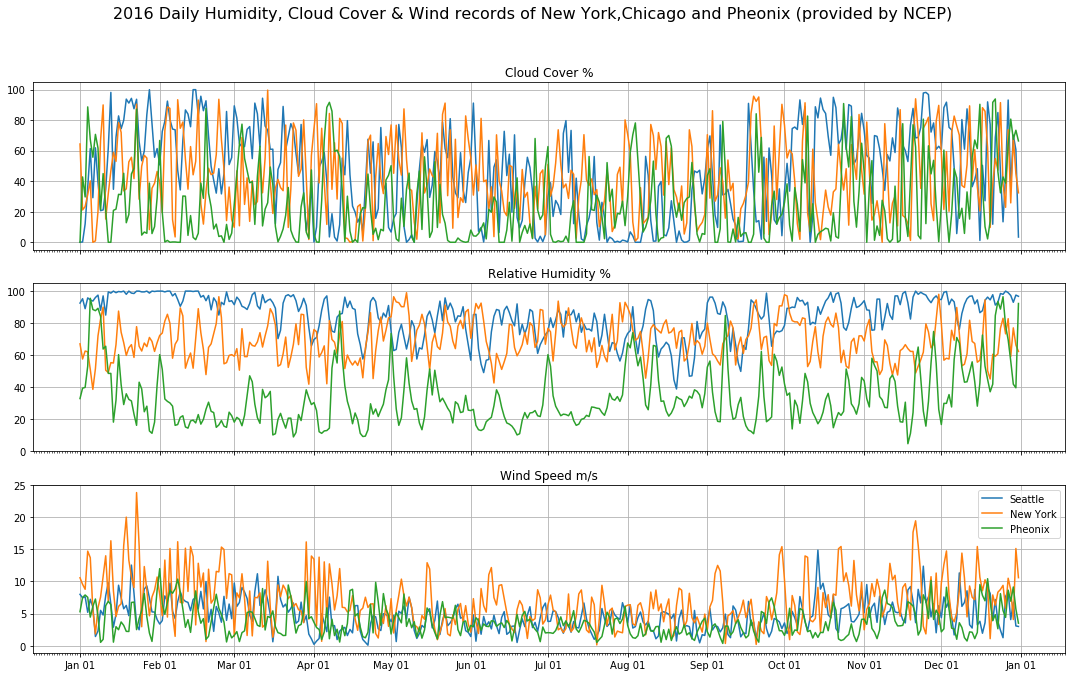

In [14]:
f, axarr = plt.subplots(3, 1, sharex=True)
f.suptitle('2016 Daily Humidity, Cloud Cover & Wind records of New York,Seattle and Pheonix (provided by NCEP)', fontsize=16)
f.set_size_inches(18.5, 10.5, forward=True)
i=0
date_range=[d.strftime('%Y%m%d') for d in pd.date_range(start_date,end_date)]
days=DayLocator()    
months = MonthLocator()  # every month
weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
dayFormatter = DateFormatter('%d')      # e.g., 12

for key in nyc_chi_dict.keys():
    axarr[i].xaxis.set_major_locator(months)
    axarr[i].xaxis.set_minor_locator(days)
    axarr[i].xaxis.set_major_formatter(weekFormatter)
    axarr[i].xaxis_date()
    axarr[i].plot_date(date_range,np.array(nyc_chi_dict[key])[:,0],'-',label="Seattle")
    axarr[i].plot_date(date_range,np.array(nyc_chi_dict[key])[:,1],'-',label="New York")
    axarr[i].plot_date(date_range,np.array(nyc_chi_dict[key])[:,2],'-',label="Pheonix")
    legend()
    axarr[i].autoscale_view()
    axarr[i].grid(True)
    if key=="CC":
        axarr[i].set_title('Cloud Cover %')
    if key=="HUM":
        axarr[i].set_title('Relative Humidity %')
    if key=="WIND":
        axarr[i].set_title('Wind Speed m/s')
    i=i+1


f.savefig('ncep_3cities.png')  